In [1]:
import yfinance as yf
import pandas as pd
from ipywidgets import Output
from sklearn.metrics import precision_score, accuracy_score,recall_score,f1_score,roc_auc_score

predictors = []

In [2]:
hold_period =5
threshold = 0.6

In [3]:
stocks = ['f','^gspc']
data =pd.DataFrame([])
pd.options.display.float_format = '{:.4f}'.format
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
first = True
predictors =[]
               
for stock in stocks:
    
    stk = yf.Ticker(stock)
    stock_data = stk.history(period='max') 
   
    
    Gap_column = f'{stock}_Gap'
    stock_data[Gap_column]=(stock_data['Open']-stock_data['Close'].shift(1))/stock_data['Close']
    predictors +=[Gap_column]
    
    if stock =="qqq":
        del (stock_data['Capital Gains'])
           
    del stock_data["Dividends"]
    del stock_data["Stock Splits"] 
    
   
    stock_data["Tomarrow"] = stock_data["Close"].shift(-hold_period)
    stock_data["Target"] = (stock_data["Tomarrow"]>stock_data["Close"]).astype(int)
    stock_data["TargetS"] = (stock_data["Tomarrow"]<stock_data["Close"]).astype(int)
    # stock_data["TargetS"] - (stock_data["Tomarrow"]<stock_data["Close"]).astype(int)
    
    
 
    
    horizons = [2,5,60,250,1000]
    # predictors = []

    for horizon in horizons:
        rolling_averages = stock_data.rolling(horizon).mean()
        yy =1

        ratio_column = f"{stock}_Close_Avg_{horizon}"
        stock_data[ratio_column] = stock_data["Close"] / rolling_averages["Close"]

        trend_column = f"{stock}_Trend_{horizon}"
        stock_data[trend_column] = stock_data.shift(1).rolling(horizon).sum()["Target"]
         
        
#         v_ratio_col =f"{stock}_VolAvg_{horizon}"
#         stock_data[v_ratio_col] = stock_data["Volume"]/rolling_averages["Volume"]
        
        predictors+= [ratio_column,trend_column]
        
    
    if  first:
        first = False
        target_stock = stock
        Entry_pr = stock_data["Open"].shift(-1)
        Exit_pr = stock_data["Open"].shift(-(hold_period+1))
        Trades = pd.concat([Entry_pr,Exit_pr],ignore_index=False,axis=1)
        Trades.columns = ['Entry','Exit']
    else:
        del stock_data['Close']
        del stock_data['Volume']
        del stock_data['Target']
        del stock_data['TargetS']
        del stock_data['Tomarrow']
        
    del stock_data["High"]
    del stock_data["Low"]  
    del stock_data["Open"]
                   
    data = pd.concat([data,stock_data],ignore_index = False,axis=1)
    

In [4]:
todays_data=data.tail(1).copy()

In [5]:
data=data.dropna()

In [6]:
 stock_data=stock_data.loc["1990-1-1":].copy()

In [7]:
import sklearn
from sklearn.ensemble import RandomForestClassifier

train = data.iloc[:-100]
test = data.iloc[-100:]

In [8]:
def backtest(data, model, predictors, long, start=2500, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model,long)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [9]:
def predict(train, test, predictors, model,long):
    if long:
        model.fit(train[predictors], train["Target"])
    else:
        model.fit(train[predictors], train["TargetS"])
        
    preds = model.predict_proba(test[predictors])[:,1]
     
    preds[preds >=threshold] = 1
    preds[preds <threshold] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    if long:
        combined = pd.concat([test["Target"], preds], axis=1)
    else:
        combined = pd.concat([test["TargetS"], preds], axis=1)
    return combined

In [10]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
modelS = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)


In [11]:
predictions = backtest(data, model, predictors,True)
predictionsS = backtest(data, modelS, predictors,False)

In [12]:
predictionsS = predictionsS.rename(columns={"Predictions":"PredictionsS"})

In [13]:
all_predictions =pd.concat([predictions,predictionsS],ignore_index = False,axis=1)

In [14]:
Trades2= pd.concat([all_predictions,Trades],ignore_index=False,axis=1)

In [15]:
recall=recall_score(predictions["Target"], predictions["Predictions"])
prec = precision_score(predictions["Target"], predictions["Predictions"])
acc = accuracy_score(predictions["Target"], predictions["Predictions"])
f1 = f1_score(predictions["Target"], predictions["Predictions"])

In [16]:
recallS=recall_score(predictionsS["TargetS"], predictionsS["PredictionsS"])
precS = precision_score(predictionsS["TargetS"], predictionsS["PredictionsS"])
accS = accuracy_score(predictionsS["TargetS"], predictionsS["PredictionsS"])
f1S = f1_score(predictionsS["TargetS"], predictionsS["PredictionsS"])

In [17]:
feature_imp=pd.Series( model.feature_importances_).sort_index(ascending=True)
feature_impS=pd.Series( modelS.feature_importances_).sort_index(ascending=True)


In [18]:
pred=pd.Series(predictors)

In [19]:
predictors2=todays_data

In [20]:
del predictors2["Close"]
del predictors2["Volume"]
del predictors2["Tomarrow"]
del predictors2["Target"]
del predictors2["TargetS"]

In [21]:
# res = model.predict(predictors2)

In [22]:
# print(pd.concat([pred,feature_imp],axis=1))

In [23]:
# print(pd.concat([pred,feature_impS],axis=1))

In [24]:
predictions["Predictions"].tail(250).value_counts()

Predictions
0.0000    141
1.0000    109
Name: count, dtype: int64

In [25]:
predictionsS["PredictionsS"].tail(250).value_counts()

PredictionsS
0.0000    141
1.0000    109
Name: count, dtype: int64

In [26]:
print("baseline: ", predictions["Target"].tail(250).value_counts() / predictions.tail(250).shape[0])

baseline:  Target
0.0000   0.5040
1.0000   0.4960
Name: count, dtype: float64


In [27]:
print("baselineS: ", predictionsS["TargetS"].tail(250).value_counts() / predictionsS.tail(250).shape[0])

baselineS:  TargetS
0.0000   0.5040
1.0000   0.4960
Name: count, dtype: float64


In [28]:
res = model.predict(predictors2)
resS = modelS.predict(predictors2)

In [29]:
print('accuracy:  ',format(acc,'.4f'),'  (TP + TN)/(TP + TN + FP +FN)' )
print('recall:    ',format(recall,'.4f'),'  TP/(TP+FN)')
print('precision: ',format(prec,'.4f'),'  TP/(TP + FP)')
print('f1:        ',format(f1,'.4f'),'  (precision * recall)/(precision + recall')

accuracy:   0.7761   (TP + TN)/(TP + TN + FP +FN)
recall:     0.7010   TP/(TP+FN)
precision:  0.8279   TP/(TP + FP)
f1:         0.7592   (precision * recall)/(precision + recall


In [30]:
print('accuracyS:  ',format(accS,'.4f'),' (TP + TN)/(TP + TN + FP +FN)' )
print('recallS:    ',format(recallS,'.4f'),' TP/(TP+FN)')
print('precisionS: ',format(prec,'.4f'),' TP/(TP + FP)')
print('f1S:        ',format(f1S,'.4f'),' (precision * recall)/(precision + recall')

accuracyS:   0.7669  (TP + TN)/(TP + TN + FP +FN)
recallS:     0.6467  TP/(TP+FN)
precisionS:  0.8279  TP/(TP + FP)
f1S:         0.7271  (precision * recall)/(precision + recall


In [31]:
# def current_price(instrument):
    
    # return format(data["Close"].iloc[-1],'.3f')
    # return data
    
# print(target_stock,": ", current_price(target_stock))

In [32]:
if res:
    print('trade Long')
    todays_data = yf.Ticker(target_stock).history(period="1d", interval="1d")
    tdayss_data
else:
    print('stand down going Long')
        

stand down going Long


In [33]:
if resS:
    
    print('trade Short')
#     todays_trade = yf.Ticker(target_stock).history(period="1d", interval="1d")
#     todays_trade['Date'] = todays_trade.index[:12]
#     todays_trade.insert(0, 'Date', todays_trade.pop('Date'))
    
    # print(todays_trade['Open'])
    
    # todays_trade.to_csv('trade.csv', index=True)
    
    
else:
    print('stand down Shorting')
        

trade Short


In [34]:
Trades2 = Trades2.dropna()

In [35]:
Trades2['Longs']=(Trades2['Predictions']*(Trades2['Exit']-Trades2['Entry']))/Trades2['Entry']/hold_period

Trades2['Shorts']= (Trades2['PredictionsS']*(Trades2['Entry']-Trades2['Exit']))/Trades2['Entry']/hold_period


In [36]:
Trade_3 = Trades2.tail(250).copy()

In [37]:
Trade_3['Longs_cum']=Trade_3['Longs'].cumsum()
Trade_3['Short_cum']=Trade_3['Shorts'].cumsum()
Trade_3['Total_cum'] = Trade_3['Longs_cum']+Trade_3['Short_cum']

In [38]:
avg_share_price = Trade_3['Entry'].sum()/250

In [39]:
long_total_profit = Trade_3['Longs_cum'].tail(1).copy()
short_total_profit= Trade_3['Short_cum'].tail(1).copy()

In [40]:
long_total_profit

Date
2024-03-07 00:00:00-05:00   0.6982
Name: Longs_cum, dtype: float64

In [41]:
short_total_profit

Date
2024-03-07 00:00:00-05:00   0.5763
Name: Short_cum, dtype: float64

In [42]:
LongAPR = long_total_profit
ShortAPR = short_total_profit
TotalAPR=  LongAPR + ShortAPR

In [43]:
returns = pd.concat([LongAPR,ShortAPR,TotalAPR],ignore_index=False,axis=1)

<Axes: xlabel='Date'>

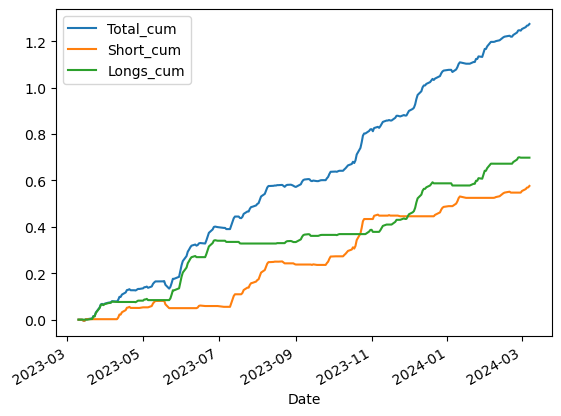

In [44]:
Trade_3.plot.line(y=['Total_cum','Short_cum','Longs_cum'],use_index=True)


### Random Test

In [119]:
import numpy as np

start_r = (np.random.randint(500, 2500))

In [120]:
test_r = data.iloc[-start_r:(-start_r+250)].copy()

In [121]:
start_r

1229

In [122]:
 preds_r = model.predict_proba(test_r[predictors])[:,1]
     
preds_r[preds_r >=threshold] = 1
preds_r[preds_r <threshold] = 0
preds_r = pd.Series(preds_r, index=test_r.index, name="Predictions")
combined_r = pd.concat([test_r["Target"], preds_r], axis=1)
    

In [123]:
predsS_r = modelS.predict_proba(test_r[predictors])[:,1]
     
predsS_r[predsS_r >=threshold] = 1
predsS_r[predsS_r <threshold] = 0
predsS_r = pd.Series(predsS_r, index=test_r.index, name="Predictions")
combinedS_r = pd.concat([test_r["TargetS"], predsS_r], axis=1)
combinedS_r = combinedS_r.rename(columns={"Predictions":"PredictionsS"})

In [124]:
all_predictions_r =pd.concat([combined_r,combinedS_r],ignore_index = False,axis=1)


In [125]:
Trades2_r= pd.concat([all_predictions_r,Trades],ignore_index=False,axis=1)

In [126]:
Trades2_r =Trades2_r.dropna()

In [127]:
Trades2_r['Longs']=(Trades2_r['Predictions']*(Trades2_r['Exit']-Trades2_r['Entry']))/Trades2_r['Entry']/hold_period

Trades2_r['Shorts']= (Trades2_r['PredictionsS']*(Trades2_r['Entry']-Trades2_r['Exit']))/Trades2_r['Entry']/hold_period


In [128]:
Trades2_r['Longs_cum']=Trades2_r['Longs'].cumsum()
Trades2_r['Short_cum']=Trades2_r['Shorts'].cumsum()
Trades2_r['Total_cum'] = Trades2_r['Longs_cum']+Trades2_r['Short_cum']

<Axes: xlabel='Date'>

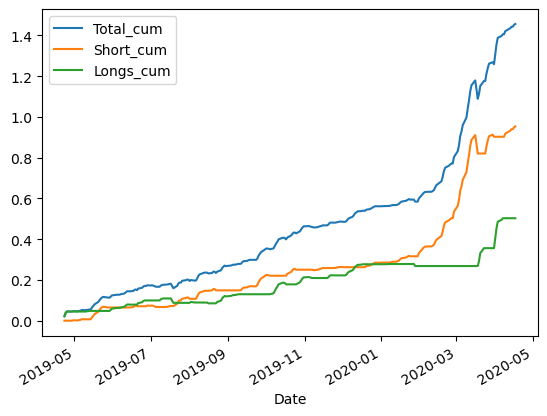

In [129]:
Trades2_r.plot.line(y=['Total_cum','Short_cum','Longs_cum'],use_index=True)
